In [1]:
import salem 
import xarray as xr
import pandas as pd
import xesmf as xe
import matplotlib.pyplot as plt
import glob
import numpy as np

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import xarray as xr
from netCDF4 import Dataset
from wrf import getvar

# 打开 NetCDF 文件
fn = '/exports/d4/xuejingkai/WRF/work/LC/case_taian_2022070900/runwrf/wrfout_d02_2022-07-24_09:00:00'
ncfile = Dataset(fn)

# 需要读取的变量列表
k1 = ['SWDOWN']
k0 = ['height', 'pressure', 'PBLH', 'rh', 'tk', 'ua', 'va']

# 创建一个空的 xarray 数据集
dataset = xr.Dataset()

# 读取 k1 列表中的变量
for var in k1:
    data = getvar(ncfile, var)
    dataset[var] = data#xr.DataArray(data, dims=('Time', 'south_north', 'west_east'))

# 读取 k0 列表中的变量
for var in k0:
    data = getvar(ncfile, var)
    dataset[var] = data#xr.DataArray(data, dims=('Time', 'bottom_top', 'south_north', 'west_east'))

# 关闭 NetCDF 文件
ncfile.close()

In [3]:
dataset=dataset.assign_coords(coords=dict(
        lon=(["south_north", "west_east"], dataset.XLONG.values),
        lat=(["south_north", "west_east"], dataset.XLAT.values),
        Time=pd.to_datetime(dataset.Time.values.astype(str), format="%Y-%m-%dT%H:%M:%S")
    )).sel(bottom_top=3)

In [4]:
ds=dataset
ds

<xarray.Dataset>
Dimensions:   (south_north: 350, west_east: 300)
Coordinates:
    XLONG     (south_north, west_east) float32 115.1 115.2 115.2 ... 118.8 118.8
    XLAT      (south_north, west_east) float32 34.39 34.39 34.39 ... 37.86 37.86
    XTIME     float32 2.214e+04
    Time      datetime64[ns] 2022-07-24T09:00:00
    lon       (south_north, west_east) float32 115.1 115.2 115.2 ... 118.8 118.8
    lat       (south_north, west_east) float32 34.39 34.39 34.39 ... 37.86 37.86
Dimensions without coordinates: south_north, west_east
Data variables:
    SWDOWN    (south_north, west_east) float32 460.2 459.9 459.9 ... 411.4 411.1
    height    (south_north, west_east) float32 157.4 157.4 157.4 ... 103.1 102.8
    pressure  (south_north, west_east) float32 985.7 985.8 985.7 ... 990.9 991.0
    PBLH      (south_north, west_east) float32 1.859e+03 1.561e+03 ... 1.863e+03
    rh        (south_north, west_east) float32 48.51 48.71 48.89 ... 38.75 40.04
    tk        (south_north, west_east) float32 305.1 305.1 305.1 ... 306.8 306.6
    ua        (south_north, west_east) float32 -1.468 -1.462 ... 1.39 0.5218
    va        (south_north, west_east) float32 6.761 6.737 6.696 ... 4.513 4.954

In [9]:
def create_regridder(ds, ds_out):
    # Assuming you have xesmf library installed
    regridder = xe.Regridder(ds, ds_out, 'bilinear', unmapped_to_nan=True)
    return regridder

lat0=ds.lat.min()
lat1=ds.lat.max()
lon0=ds.lon.min()
lon1=ds.lon.max()

dx=0.01
ds_out = xr.Dataset(
    {
        "lat": ("lat", np.arange( lat0,lat1, dx)),
        "lon": ("lon", np.arange(lon0,lon1, dx))
    }
)
global_regridder=create_regridder(ds, ds_out)
ds_reg = global_regridder(ds)

In [10]:
ds_reg

<xarray.Dataset>
Dimensions:   (lat: 349, lon: 377)
Coordinates:
    XTIME     float32 2.214e+04
    Time      datetime64[ns] 2022-07-24T09:00:00
  * lat       (lat) float64 34.39 34.4 34.41 34.42 ... 37.84 37.85 37.86 37.87
  * lon       (lon) float64 115.1 115.1 115.1 115.1 ... 118.8 118.8 118.8 118.8
Data variables:
    SWDOWN    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    height    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    pressure  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    PBLH      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    rh        (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    tk        (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    ua        (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    va        (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    regrid_method:  bilinear

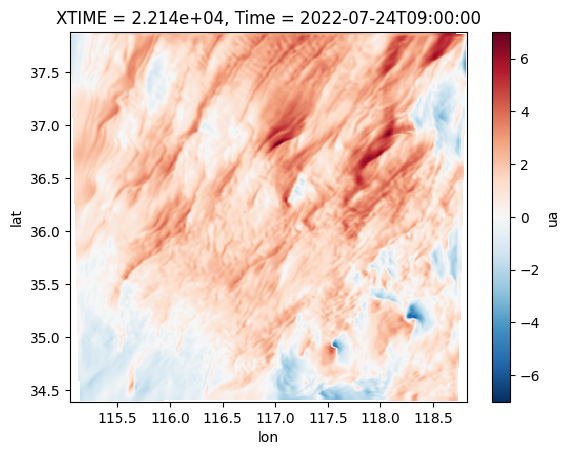

In [11]:
ds_reg.ua.plot()

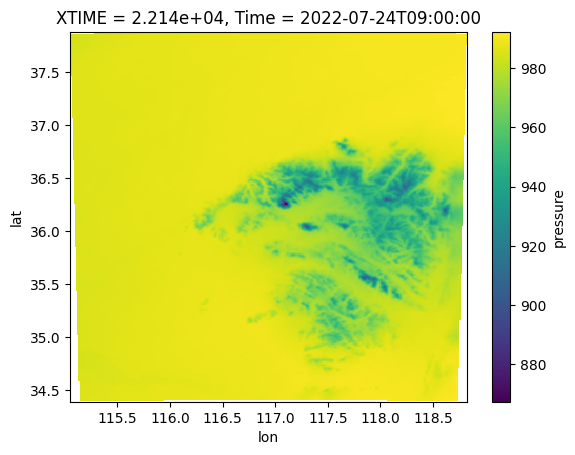

In [12]:
ds_reg.pressure.plot()